### Projeto: Análise da área de Dados


#### Contexto

- Fonte dos dados: https://www.kaggle.com/datasets/datahackers/state-of-data-brazil-20242025
- Os dados são fornecem um panorma sobre o mercado de trabalho brasileiro na área de Dados.

### Objetivos da Análise

- Entender quais são os fatores relacionados à remuneração dos profissionais que estão atuando como funcionários CLT.
- Quais decisões os profissionais de dados podem tomar durante a carreira para aumentar a probilidade de remunerações maiores?

In [28]:
import pandas as pd
import numpy as np
import re as re
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import seaborn as sns
import seaborn as sns
import textwrap

from scipy.stats import chi2_contingency


sns.set_theme(style='white', palette='Set2', context='notebook')
pd.set_option('display.max_columns', None)

from src.config import PASTA_DADOS, DADOS_TRATADO
from src.graficos import composicao_histograma_boxplot

In [2]:
base = pd.read_parquet(DADOS_TRATADO)

base.head(5)

uf_onde_mora vive_no_brasil         nivel_de_ensino  \
0           SP            Sim  Estudante de Graduação   
1           SP            Sim   Graduação/Bacharelado   
2           SC            Sim  Estudante de Graduação   
3           SP            Sim  Estudante de Graduação   
4           GO            Sim  Estudante de Graduação   

                                    área_de_formação     setor_da_empresa  \
0  Computação / Engenharia de Software / Sistemas...            Indústria   
1  Economia/ Administração / Contabilidade / Fina...      Telecomunicação   
2  Computação / Engenharia de Software / Sistemas...  Área de Consultoria   
3  Computação / Engenharia de Software / Sistemas...               Varejo   
4  Estatística/ Matemática / Matemática Computaci...   Finanças ou Bancos   

  atua_como_gestor                                       cargo_atual  \
0              Não                                       Outra Opção   
1              Não                         Analista de BI/BI Analyst   
2              Não  Engenheiro de Dados/Data Engineer/Data Architect   
3              Não                                Analytics Engineer   
4              Não             Analista de Negócios/Business Analyst   

  nivel_cargo           tempo_de_experiencia_em_dados  \
0      Júnior  Não tenho experiência na área de dados   
1      Júnior                           de 5 a 6 anos   
2      Júnior                           de 1 a 2 anos   
3      Júnior                          Menos de 1 ano   
4       Pleno                           de 1 a 2 anos   

  modelo_de_trabalho_atual    funcao_de_atuacao linguagem_R_no_trabalho  \
0   Modelo 100% presencial        Outra atuação                     Não   
1   Modelo 100% presencial  Engenharia de Dados                     Não   
2       Modelo 100% remoto  Engenharia de Dados                     Não   
3       Modelo 100% remoto     Análise de Dados                     Não   
4   Modelo 100% presencial        Outra atuação                     Não   

                                linguagem_mais_usada faixa_salarial  \
0  Não utilizo nenhuma das linguagens listadas no...          1k-2k   
1                                           C/C++/C#          6k-8k   
2                                             Python          3k-4k   
3                                             Python          4k-6k   
4                                   Visual Basic/VBA          2k-3k   

  Uso AI Generativa com foco em produtividade  
0                                         Sim  
1                                         Sim  
2                                         Não  
3                                         Sim  
4                                         Sim

In [3]:
base.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3780 entries, 0 to 3779
Data columns (total 15 columns):
 #   Column                                       Non-Null Count  Dtype   
---  ------                                       --------------  -----   
 0   uf_onde_mora                                 3780 non-null   category
 1   vive_no_brasil                               3780 non-null   category
 2   nivel_de_ensino                              3780 non-null   category
 3   área_de_formação                             3730 non-null   category
 4   setor_da_empresa                             3780 non-null   category
 5   atua_como_gestor                             3780 non-null   category
 6   cargo_atual                                  3780 non-null   category
 7   nivel_cargo                                  3780 non-null   category
 8   tempo_de_experiencia_em_dados                3780 non-null   category
 9   modelo_de_trabalho_atual                     3780 non-null   ca

In [4]:
base.describe()

uf_onde_mora vive_no_brasil nivel_de_ensino  \
count          3780           3780            3780   
unique           25              2               6   
top              SP            Sim   Pós-graduação   
freq           1632           3747            1540   

                                         área_de_formação    setor_da_empresa  \
count                                                3730                3780   
unique                                                  8                  21   
top     Computação / Engenharia de Software / Sistemas...  Finanças ou Bancos   
freq                                                 1494                 937   

       atua_como_gestor                     cargo_atual nivel_cargo  \
count              3780                            3780        3780   
unique                2                              16           4   
top                 Não  Analista de Dados/Data Analyst      Sênior   
freq               3045                             797        1328   

       tempo_de_experiencia_em_dados modelo_de_trabalho_atual  \
count                           3780                     3780   
unique                             7                        4   
top                    de 3 a 4 anos       Modelo 100% remoto   
freq                            1160                     1707   

       funcao_de_atuacao linguagem_R_no_trabalho linguagem_mais_usada  \
count               3780                    3780                 3780   
unique                 6                       2                   13   
top     Análise de Dados                     Não                  SQL   
freq                1389                    3525                 1470   

       faixa_salarial Uso AI Generativa com foco em produtividade  
count            3780                                        3780  
unique             12                                           2  
top            8k-12k                                         Sim  
freq              942                                        2522

In [5]:
coluna_alvo = 'faixa_salarial'

In [6]:
colunas_grandes = ['uf_onde_mora',
                  'setor_da_empresa',
                   'cargo_atual',
                   'linguagem_mais_usada'
                  ]

In [7]:
colunas = list(base.columns)
colunas.remove(coluna_alvo)
colunas

['uf_onde_mora',
 'vive_no_brasil',
 'nivel_de_ensino',
 'área_de_formação',
 'setor_da_empresa',
 'atua_como_gestor',
 'cargo_atual',
 'nivel_cargo',
 'tempo_de_experiencia_em_dados',
 'modelo_de_trabalho_atual',
 'funcao_de_atuacao',
 'linguagem_R_no_trabalho',
 'linguagem_mais_usada',
 'Uso AI Generativa com foco em produtividade']

In [8]:
colunas_binarias = base.nunique()[base.nunique() == 2].index.tolist()

colunas_binarias

['vive_no_brasil',
 'atua_como_gestor',
 'linguagem_R_no_trabalho',
 'Uso AI Generativa com foco em produtividade']

In [9]:
colunas_nao_binarias = list(set(colunas) - set(colunas_binarias))
#colunas_nao_binarias.remove(colunas_grandes)
colunas_nao_binarias

['modelo_de_trabalho_atual',
 'nivel_cargo',
 'linguagem_mais_usada',
 'tempo_de_experiencia_em_dados',
 'funcao_de_atuacao',
 'uf_onde_mora',
 'área_de_formação',
 'nivel_de_ensino',
 'setor_da_empresa',
 'cargo_atual']

In [10]:
colunas_nao_binarias = [item for item in colunas_nao_binarias if item not in colunas_grandes]


In [11]:
colunas_nao_binarias

['modelo_de_trabalho_atual',
 'nivel_cargo',
 'tempo_de_experiencia_em_dados',
 'funcao_de_atuacao',
 'área_de_formação',
 'nivel_de_ensino']

In [12]:
base[coluna_alvo].value_counts()

faixa_salarial
8k-12k     942
12k-16k    599
6k-8k      567
4k-6k      506
16k-20k    353
3k-4k      211
20k-25k    168
2k-3k      155
25k-30k    100
30k-40k     85
40k+        51
1k-2k       43
0-1k         0
Name: count, dtype: int64

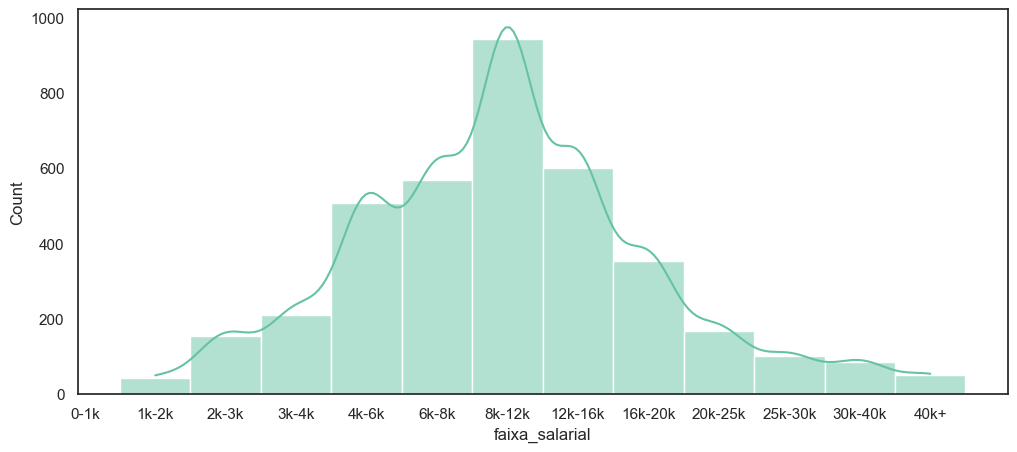

In [13]:
fig = plt.figure(figsize=(12,5))
sns.histplot(data=base, x=coluna_alvo, kde=True)
plt.show();

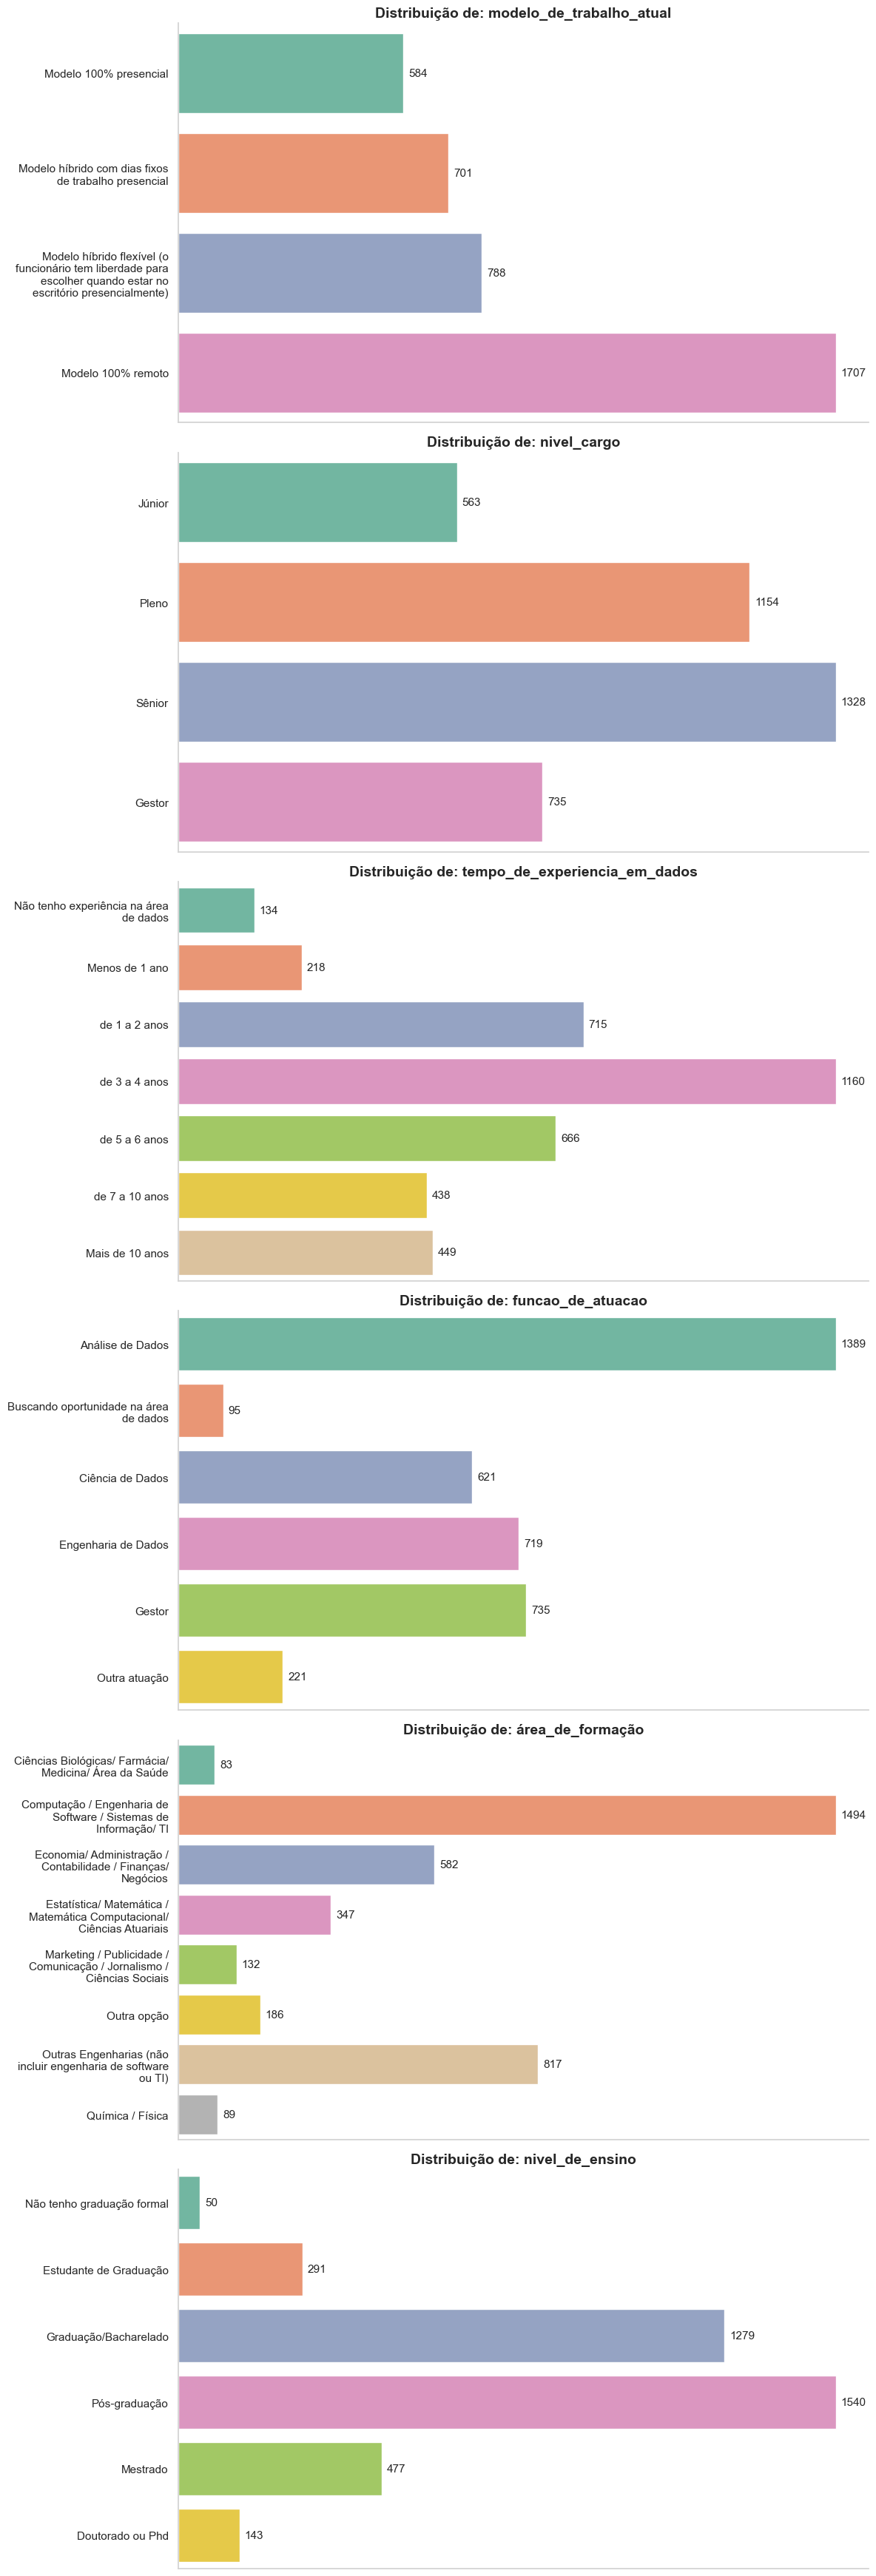

In [14]:

import textwrap

fig, axs = plt.subplots(6, 1, figsize=(12, 35))

for ax, coluna in zip(axs.flatten(), colunas_nao_binarias):
    sns.countplot(data=base, y=coluna, ax=ax, hue=coluna, legend=False)
    
    # 1. Ajuste das legendas com Wrap (como feito anteriormente)
    ticks = ax.get_yticks()
    labels = [textwrap.fill(label.get_text(), 30) for label in ax.get_yticklabels()]
    ax.set_yticks(ticks)
    ax.set_yticklabels(labels)
    
    # 2. A CORREÇÃO: Adicionar rótulos em TODOS os grupos de barras
    # Percorremos cada container para garantir que nenhuma barra fique sem número
    for container in ax.containers:
        ax.bar_label(container, padding=5, fontsize=11)
    
    # Estética
    ax.set_title(textwrap.fill(f'Distribuição de: {coluna}', 50), fontsize=14, fontweight='bold')
    ax.set_xlabel('Contagem')
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.set_xticks([])

    # PASSO 1: Remova as bordas (Spines)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color('#D3D3D3') # Deixa a borda restante suave
    ax.spines['bottom'].set_color('#D3D3D3')

plt.tight_layout()
plt.show();

In [15]:
colunas_grandes

['uf_onde_mora', 'setor_da_empresa', 'cargo_atual', 'linguagem_mais_usada']

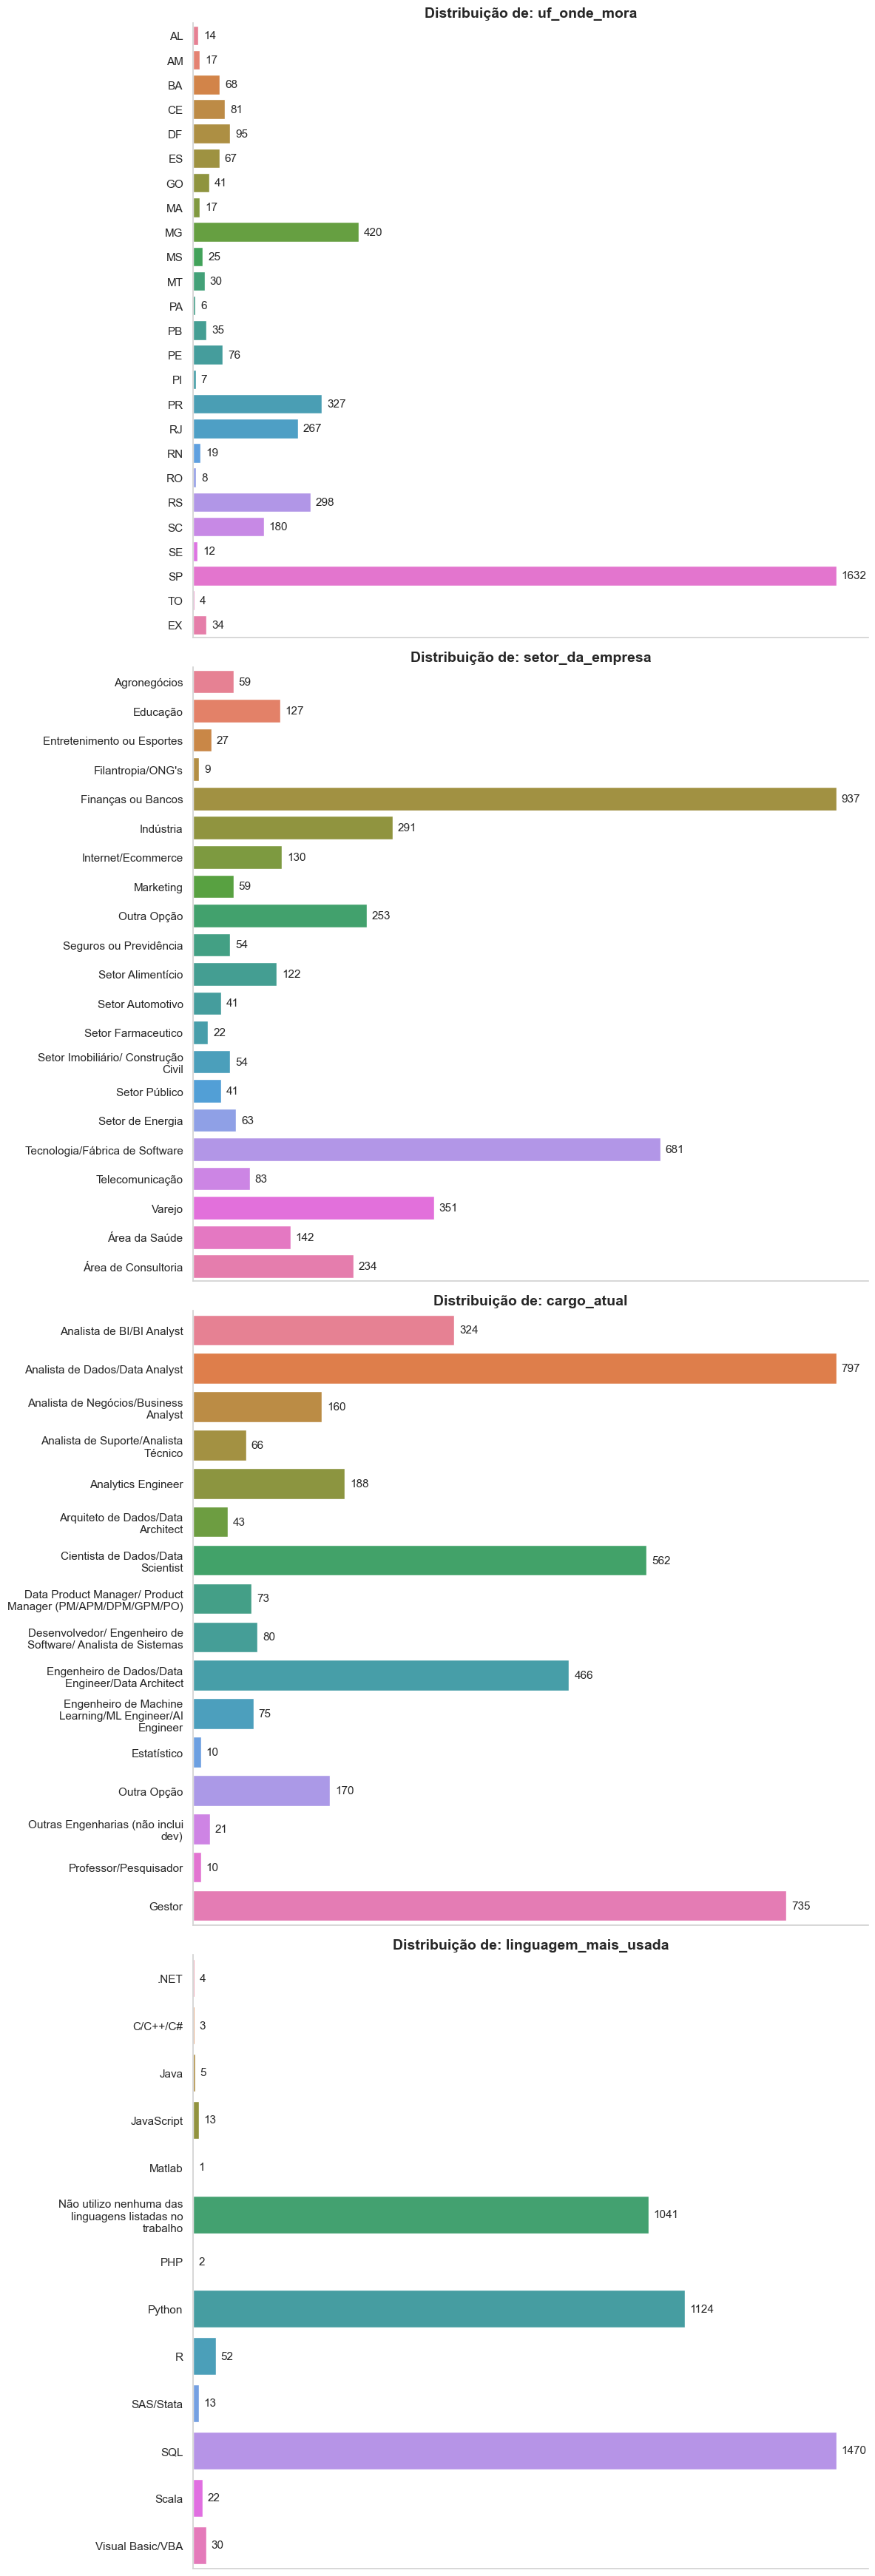

In [16]:


fig, axs = plt.subplots(4, 1, figsize=(12, 35))

for ax, coluna in zip(axs.flatten(), colunas_grandes):
    sns.countplot(data=base, y=coluna, ax=ax, hue=coluna, legend=False)
    
    # 1. Ajuste das legendas com Wrap (como feito anteriormente)
    ticks = ax.get_yticks()
    labels = [textwrap.fill(label.get_text(), 30) for label in ax.get_yticklabels()]
    ax.set_yticks(ticks)
    ax.set_yticklabels(labels)
    
    # 2. A CORREÇÃO: Adicionar rótulos em TODOS os grupos de barras
    # Percorremos cada container para garantir que nenhuma barra fique sem número
    for container in ax.containers:
        ax.bar_label(container, padding=5, fontsize=11)
    
    # Estética
    ax.set_title(textwrap.fill(f'Distribuição de: {coluna}', 50), fontsize=14, fontweight='bold')
    ax.set_xlabel('Contagem')
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.set_xticks([])

    # PASSO 1: Remova as bordas (Spines)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color('#D3D3D3') # Deixa a borda restante suave
    ax.spines['bottom'].set_color('#D3D3D3')

plt.tight_layout()
plt.show();

#### Estudo das colunas categóricas Binárias

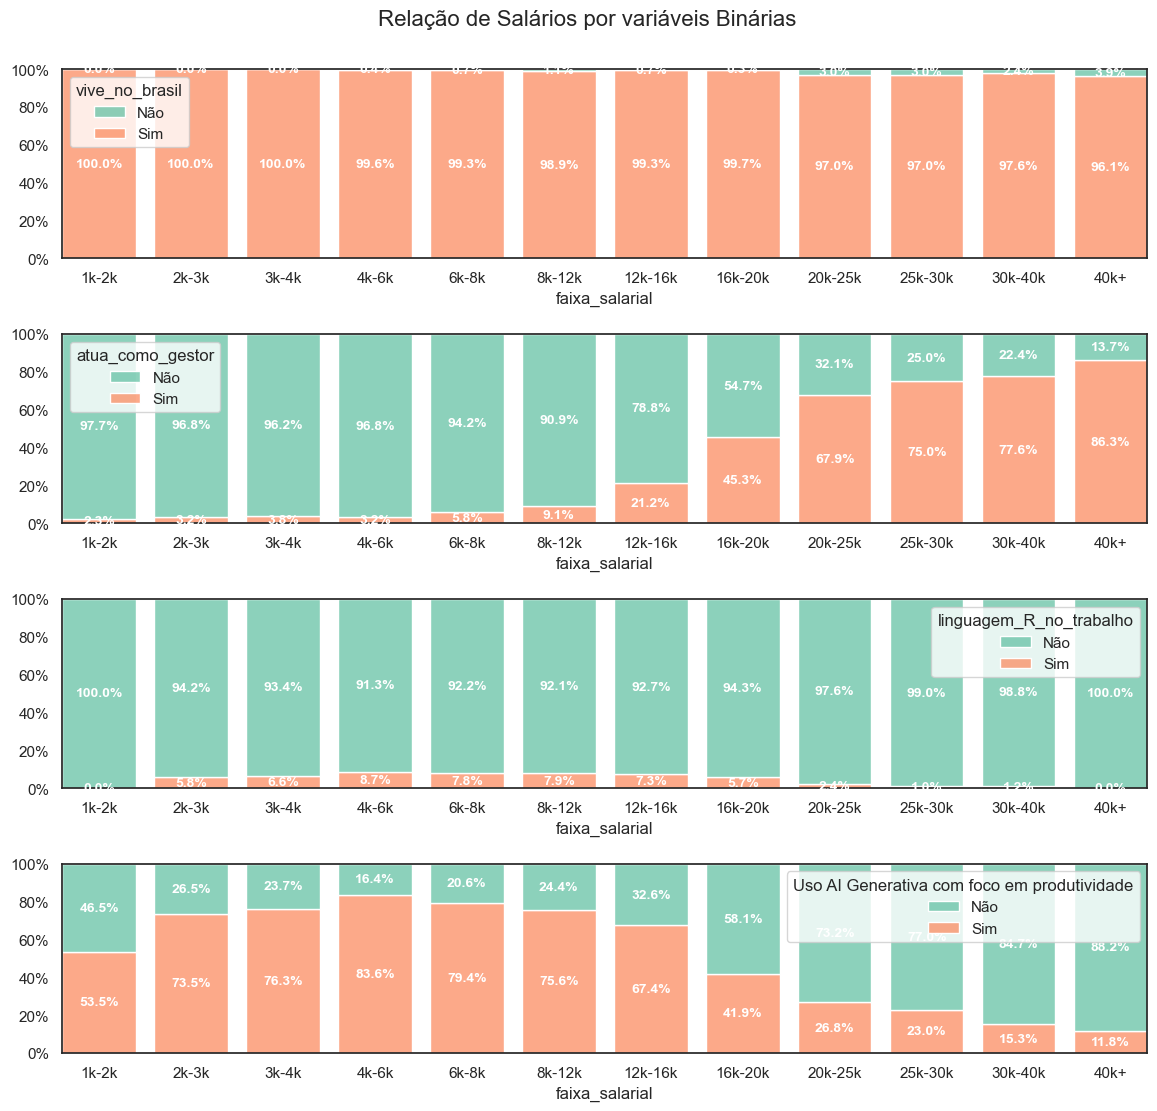

In [17]:


fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(14, 12), sharey=True)

for i, coluna in enumerate(colunas_binarias):
    h = sns.histplot(x=coluna_alvo, 
                     hue=coluna, 
                     data=base, 
                     multiple='fill', 
                     ax=axs.flat[i], 
                     stat='percent',
                     shrink=0.8)
    h.tick_params(axis='x', labelrotation=0)
    h.grid(False)

    h.yaxis.set_major_formatter(PercentFormatter(1))
    h.set_ylabel('')

    for bar in h.containers:
        h.bar_label(bar, label_type='center', labels=[f'{b.get_height():.1%}' for b in bar], color='white', weight='bold', fontsize=10)

    legend = h.get_legend()
    #legend.remove()

labels = [text.get_text() for text in legend.get_texts()]

#fig.legend(handles=legend.legend_handles, labels=labels, loc='right', ncols=2, title='Faixa de Salário', bbox_to_anchor=(0.9, 0.965))
fig.suptitle('Relação de Salários por variáveis Binárias', fontsize=16)

fig.align_labels()

plt.subplots_adjust(wspace=0.4, hspace=0.4, top=0.93)

plt.show()

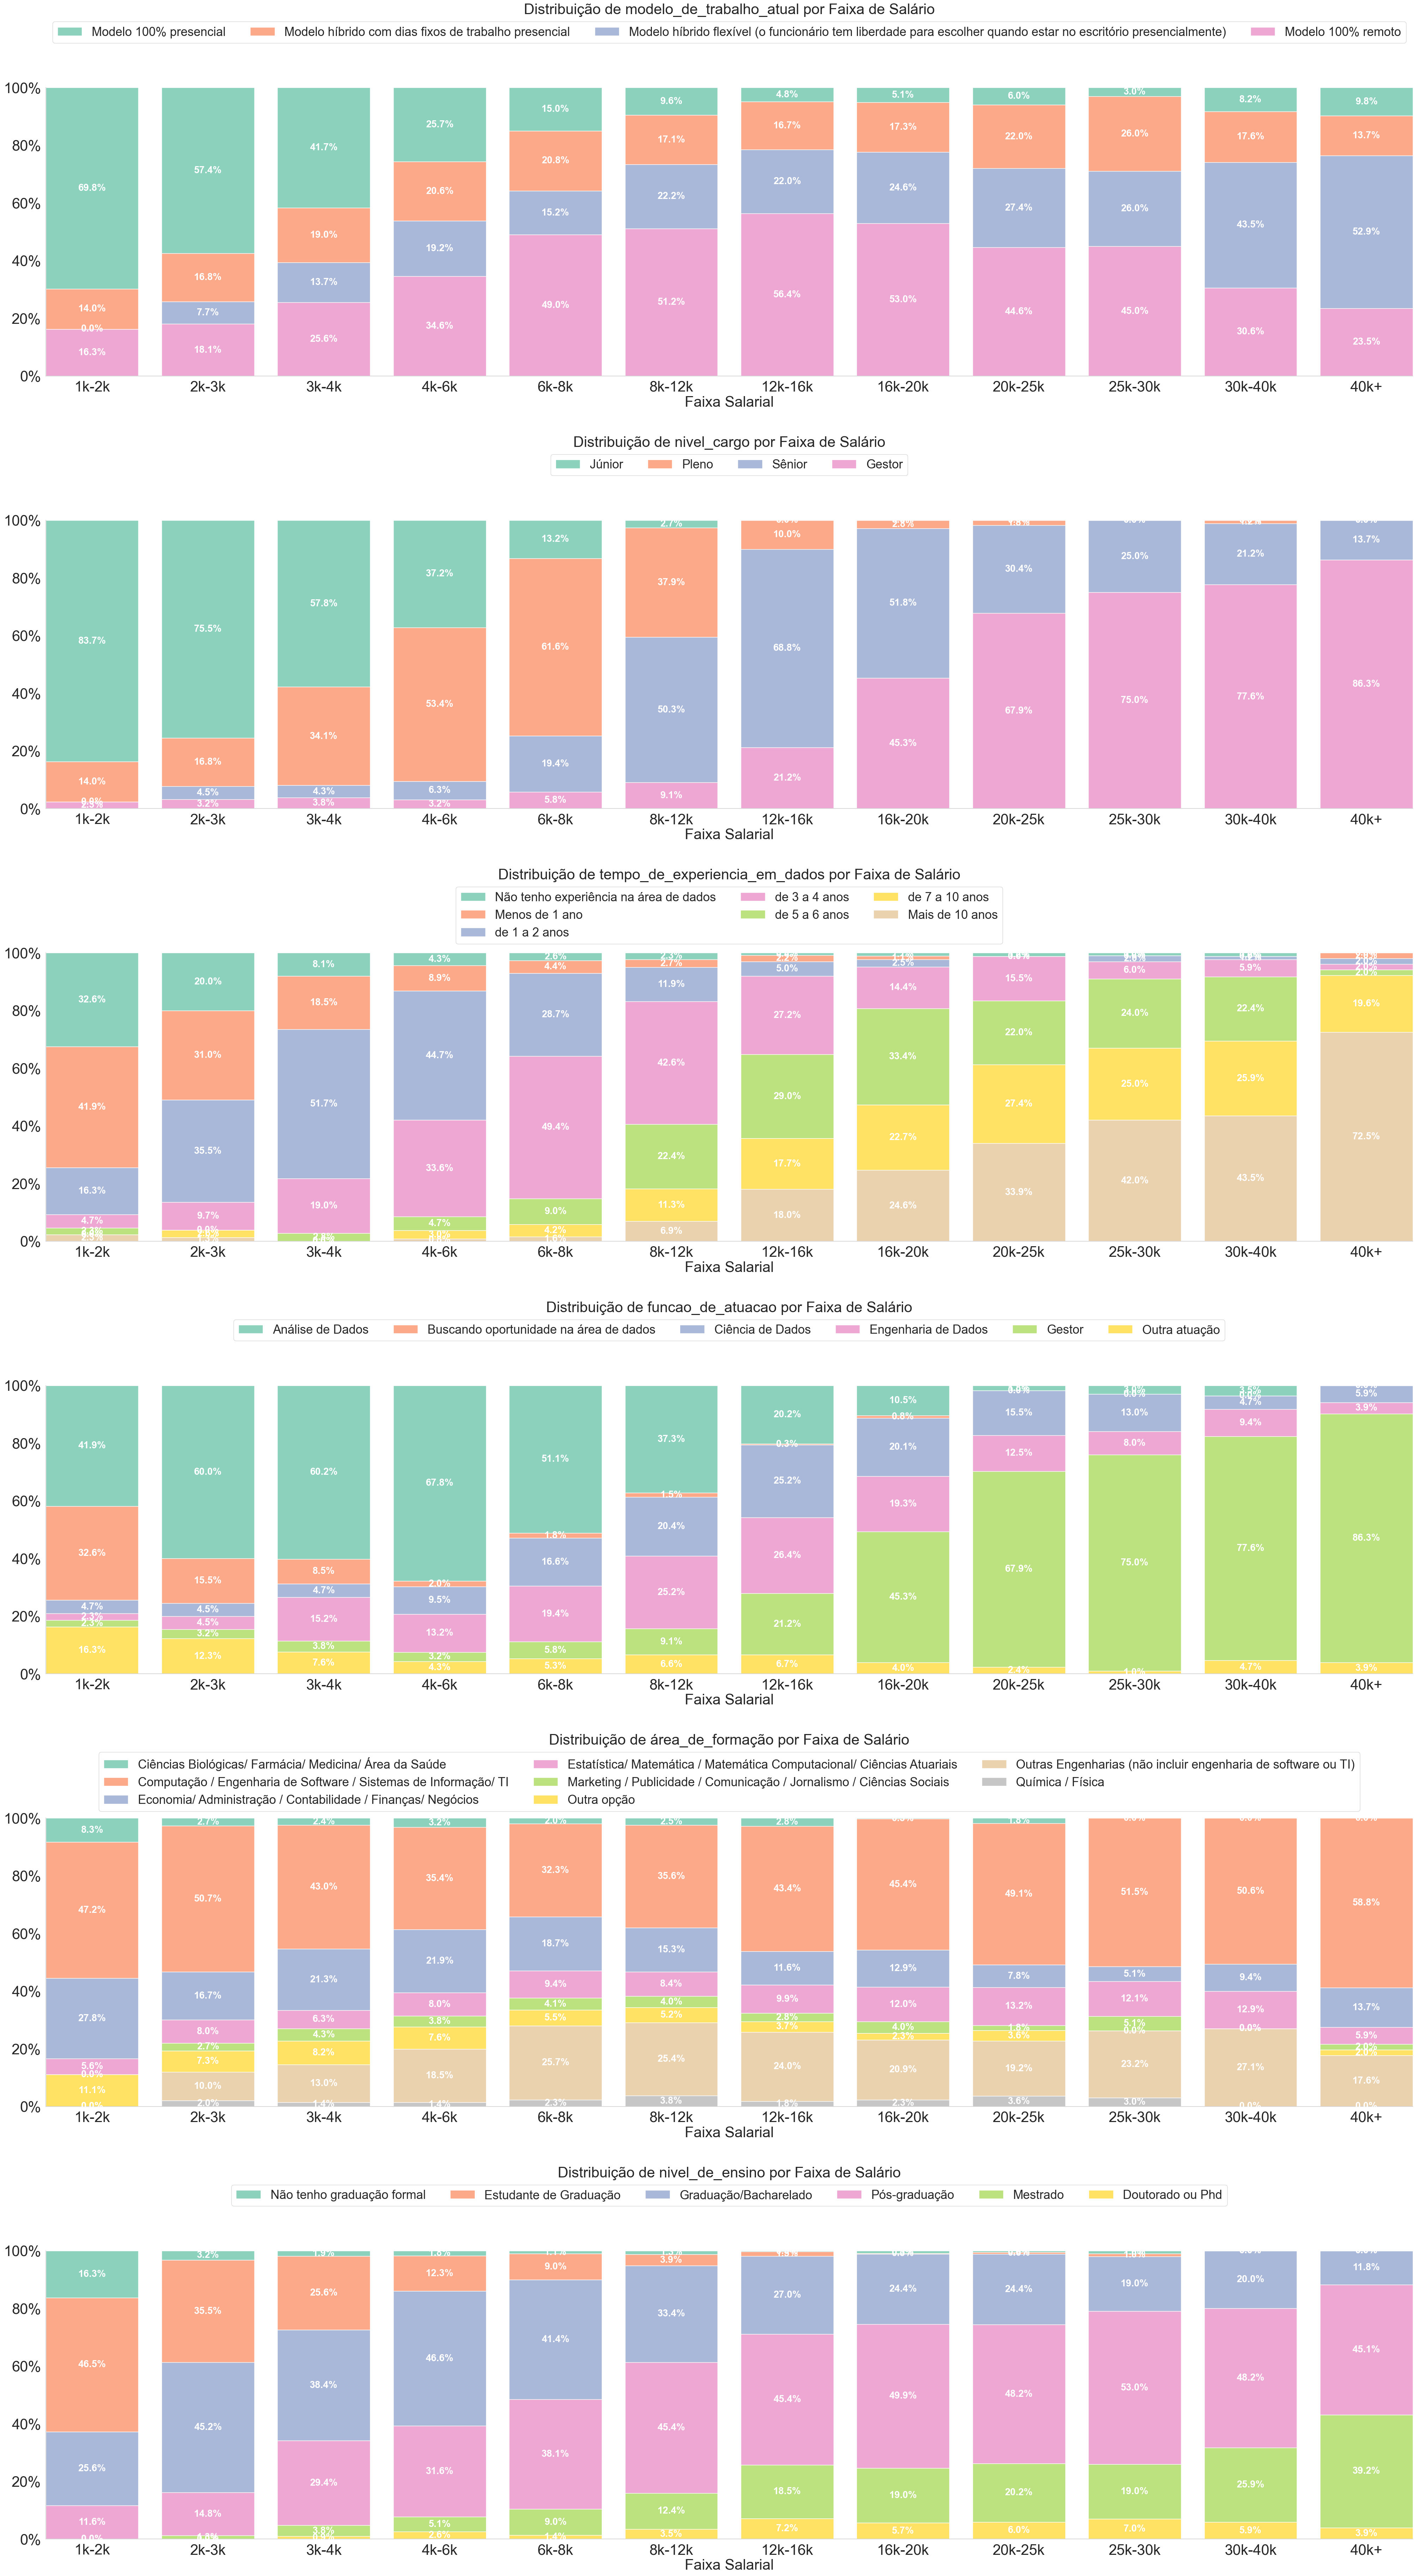

In [18]:
### Analisando outras colunas

colunas_analise = colunas_nao_binarias
fig, axs = plt.subplots(nrows=6, ncols=1, figsize=(50, 50))

for ax, coluna in zip(axs.flatten(),colunas_analise):
    h = sns.histplot(x=coluna_alvo, 
                     hue=coluna, 
                     data=base, 
                     multiple='fill', 
                     ax=ax, 
                     stat='percent',
                     shrink=0.8)
    h.tick_params(axis='x', labelrotation=0, labelsize = 30)
    h.tick_params(axis='y', labelrotation=0, labelsize = 30)
    
    h.grid(False)

    h.yaxis.set_major_formatter(PercentFormatter(1),)
    h.set_ylabel('')
    h.set_xlabel('Faixa Salarial', fontsize = 30 )

    h.spines['top'].set_visible(False)
    h.spines['right'].set_visible(False)
    h.spines['left'].set_color('#D3D3D3') # Deixa a borda restante suave
    h.spines['bottom'].set_color('#D3D3D3')

    for bar in h.containers:
        h.bar_label(bar, label_type='center', labels=[f'{b.get_height():.1%}' for b in bar], color='white', weight='bold', fontsize=20)

    legend = h.get_legend()

    labels = [text.get_text() for text in legend.get_texts()]

    numero_itens = len(base[coluna].cat.categories)

    ax.legend(
        handles = legend.legend_handles,
        labels=labels,
        loc= 'upper center',
        ncols = numero_itens if numero_itens <= 6 else 3,
        bbox_to_anchor = (0.5,1.25),
        fontsize = 25
    )

#fig.legend(handles=legend.legend_handles, labels=labels, loc='right', ncols=2, title='Diabetes', bbox_to_anchor=(0.9, 0.965))
#fig.suptitle('Relação de Diabetes por variável categórica', fontsize=16)

    ax.set_title(f"Distribuição de {coluna} por Faixa de Salário", fontsize=30, pad = 150)

fig.align_labels()

plt.subplots_adjust(wspace=0.3, hspace=0.5, top=1.5)

plt.show()

In [30]:
colunas_grandes

['uf_onde_mora', 'setor_da_empresa', 'cargo_atual', 'linguagem_mais_usada']

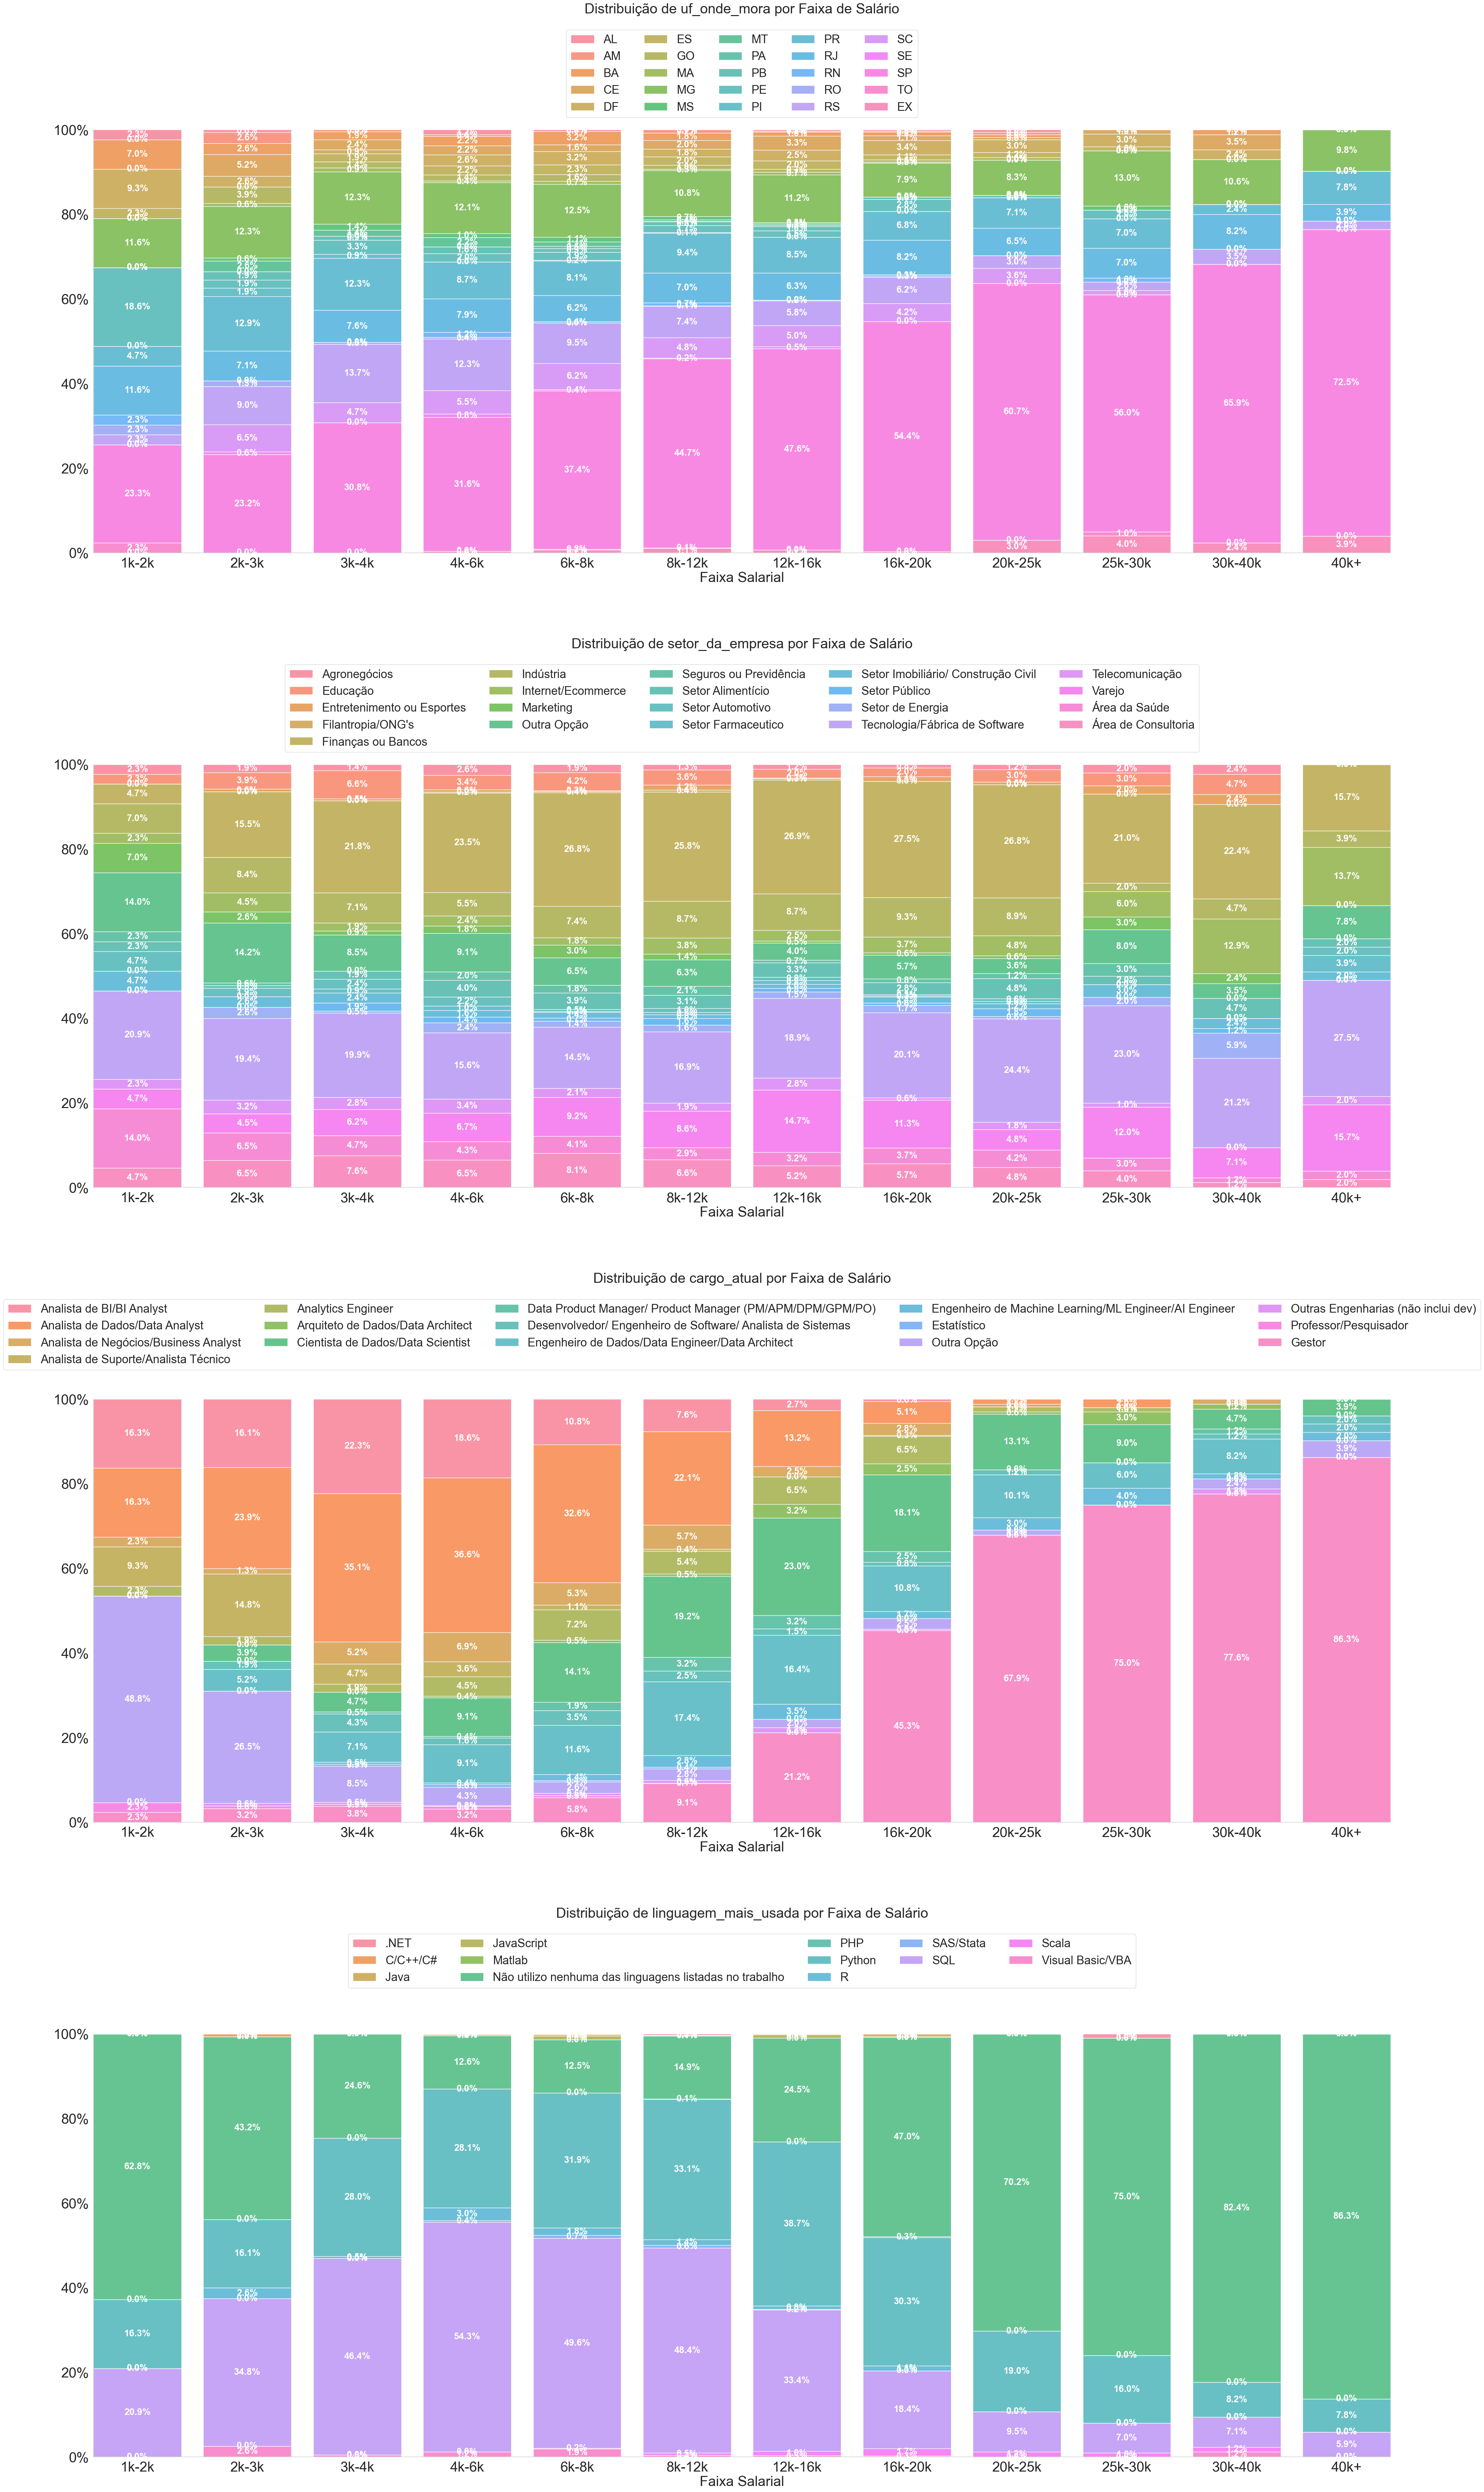

In [37]:
### Analisando outras colunas

colunas_analise = colunas_grandes
fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(50, 50))

for ax, coluna in zip(axs.flatten(),colunas_analise):
    h = sns.histplot(x=coluna_alvo, 
                     hue=coluna, 
                     data=base, 
                     multiple='fill', 
                     ax=ax, 
                     stat='percent',
                     shrink=0.8)
    h.tick_params(axis='x', labelrotation=0, labelsize = 30)
    h.tick_params(axis='y', labelrotation=0, labelsize = 30)
    
    h.grid(False)

    h.yaxis.set_major_formatter(PercentFormatter(1),)
    h.set_ylabel('')
    h.set_xlabel('Faixa Salarial', fontsize = 30 )

    h.spines['top'].set_visible(False)
    h.spines['right'].set_visible(False)
    h.spines['left'].set_color('#D3D3D3') # Deixa a borda restante suave
    h.spines['bottom'].set_color('#D3D3D3')

    for bar in h.containers:
        h.bar_label(bar, label_type='center', labels=[f'{b.get_height():.1%}' for b in bar], color='white', weight='bold', fontsize=20)

    legend = h.get_legend()

    labels = [text.get_text() for text in legend.get_texts()]

    numero_itens = len(base[coluna].cat.categories)

    ax.legend(
        handles = legend.legend_handles,
        labels=labels,
        loc= 'upper center',
        ncols = numero_itens if numero_itens <= 6 else 5,
        bbox_to_anchor = (0.5,1.25),
        fontsize = 25
    )

#fig.legend(handles=legend.legend_handles, labels=labels, loc='right', ncols=2, title='Diabetes', bbox_to_anchor=(0.9, 0.965))
#fig.suptitle('Relação de Diabetes por variável categórica', fontsize=16)

    ax.set_title(f"Distribuição de {coluna} por Faixa de Salário", fontsize=30, pad = 250)

fig.align_labels()

plt.subplots_adjust(wspace=0.3, hspace=0.5, top=1.5)

plt.show()

### Tabelas de contigencias

In [20]:
tabelas_contingencia = {}

for coluna in base.select_dtypes("category").columns:
    if coluna != coluna_alvo:
        tabelas_contingencia[coluna] = pd.crosstab(base[coluna_alvo], base[coluna])

In [22]:
for coluna in base.select_dtypes("category").columns:
    if coluna != coluna_alvo:
         display(
             pd.crosstab(
                 base[coluna_alvo], 
                 base[coluna],
                 margins = True,
                 normalize = "index",
         ).style.format("{:.2%}"))

In [25]:
for coluna, tabela in tabelas_contingencia.items():
    chi2, valor_p, _, _ = chi2_contingency(tabela)
    print(f"{coluna} - {chi2=} - {valor_p=}")

uf_onde_mora - chi2=np.float64(580.8657458674252) - valor_p=np.float64(7.176648072418712e-26)
vive_no_brasil - chi2=np.float64(28.66086272588735) - valor_p=np.float64(0.002561683180904401)
nivel_de_ensino - chi2=np.float64(878.286680616075) - valor_p=np.float64(1.0452287248189328e-148)
área_de_formação - chi2=np.float64(220.16606798087258) - valor_p=np.float64(1.0157447919322583e-15)
setor_da_empresa - chi2=np.float64(389.5868708778746) - valor_p=np.float64(1.4335122228022694e-11)
atua_como_gestor - chi2=np.float64(1213.7194339936914) - valor_p=np.float64(1.7883036779904608e-253)
cargo_atual - chi2=np.float64(2434.6630203012987) - valor_p=np.float64(0.0)
nivel_cargo - chi2=np.float64(3378.212325634226) - valor_p=np.float64(0.0)
tempo_de_experiencia_em_dados - chi2=np.float64(2548.8847278524154) - valor_p=np.float64(0.0)
modelo_de_trabalho_atual - chi2=np.float64(705.8978713590709) - valor_p=np.float64(3.2362105210872034e-127)
funcao_de_atuacao - chi2=np.float64(1983.7555775107874) - va

In [26]:
resultados_correlacao = base.select_dtypes("category").apply(lambda coluna: coluna.cat.codes).corr(method="spearman", numeric_only=False)
resultados_correlacao

uf_onde_mora  vive_no_brasil  \
uf_onde_mora                                     1.000000       -0.168262   
vive_no_brasil                                  -0.168262        1.000000   
nivel_de_ensino                                  0.021221       -0.030667   
área_de_formação                                 0.012170       -0.008987   
setor_da_empresa                                -0.038528        0.013229   
atua_como_gestor                                 0.114493        0.017365   
cargo_atual                                      0.062498        0.007269   
nivel_cargo                                      0.137556        0.003639   
tempo_de_experiencia_em_dados                    0.110801       -0.023518   
modelo_de_trabalho_atual                        -0.028201       -0.067971   
funcao_de_atuacao                                0.065040        0.002178   
linguagem_R_no_trabalho                         -0.044913        0.002565   
linguagem_mais_usada                            -0.056129       -0.013885   
faixa_salarial                                   0.191150       -0.053711   
Uso AI Generativa com foco em produtividade     -0.071704       -0.005930   

                                             nivel_de_ensino  \
uf_onde_mora                                        0.021221   
vive_no_brasil                                     -0.030667   
nivel_de_ensino                                     1.000000   
área_de_formação                                    0.116615   
setor_da_empresa                                   -0.002825   
atua_como_gestor                                    0.164676   
cargo_atual                                         0.182854   
nivel_cargo                                         0.321097   
tempo_de_experiencia_em_dados                       0.303398   
modelo_de_trabalho_atual                            0.119386   
funcao_de_atuacao                                   0.154071   
linguagem_R_no_trabalho                             0.042339   
linguagem_mais_usada                               -0.124854   
faixa_salarial                                      0.381825   
Uso AI Generativa com foco em produtividade        -0.108381   

                                             área_de_formação  \
uf_onde_mora                                         0.012170   
vive_no_brasil                                      -0.008987   
nivel_de_ensino                                      0.116615   
área_de_formação                                     1.000000   
setor_da_empresa                                     0.025390   
atua_como_gestor                                     0.001858   
cargo_atual                                         -0.056669   
nivel_cargo                                          0.015119   
tempo_de_experiencia_em_dados                       -0.084731   
modelo_de_trabalho_atual                             0.019818   
funcao_de_atuacao                                   -0.094379   
linguagem_R_no_trabalho                              0.058365   
linguagem_mais_usada                                 0.007871   
faixa_salarial                                       0.013746   
Uso AI Generativa com foco em produtividade          0.010082   

                                             setor_da_empresa  \
uf_onde_mora                                        -0.038528   
vive_no_brasil                                       0.013229   
nivel_de_ensino                                     -0.002825   
área_de_formação                                     0.025390   
setor_da_empresa                                     1.000000   
atua_como_gestor                                    -0.000679   
cargo_atual                                          0.016704   
nivel_cargo                                          0.006193   
tempo_de_experiencia_em_dados                        0.006357   
modelo_de_trabalho_atual                             0.164491   
funcao_de_atuacao              

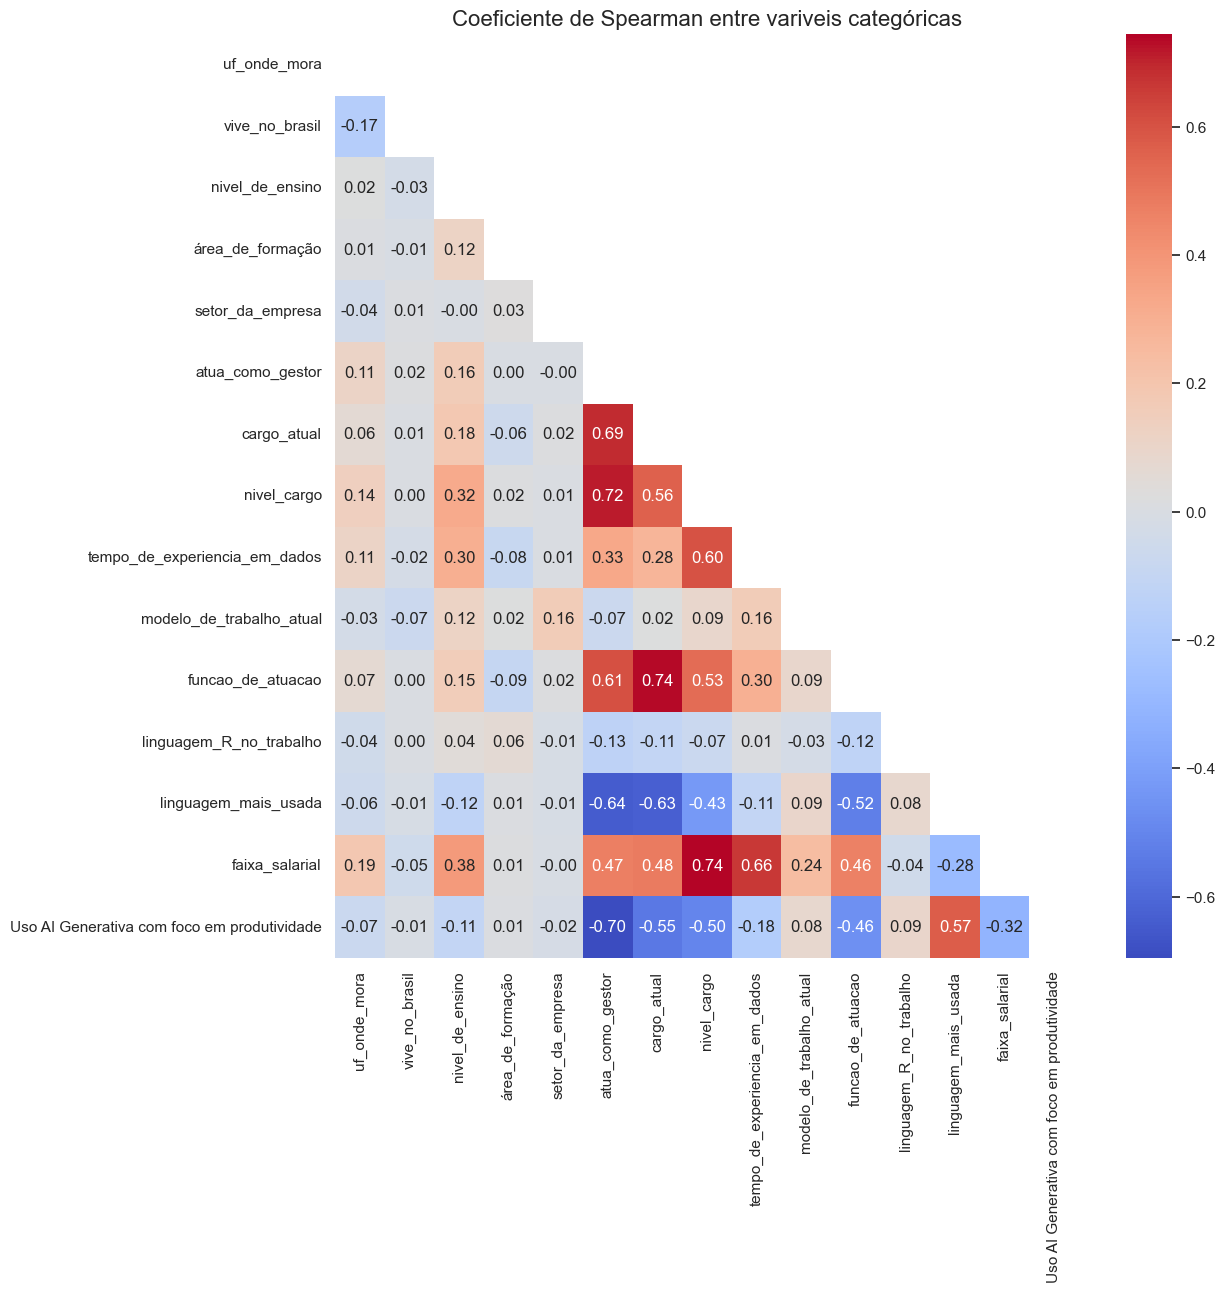

In [29]:
matriz = np.triu(resultados_correlacao)

fig, ax = plt.subplots(figsize=(12,12))


sns.heatmap(resultados_correlacao, mask=matriz, annot=True, fmt=".2f", cmap="coolwarm", ax=ax)

plt.title("Coeficiente de Spearman entre variveis categóricas", fontsize = 16)

plt.show()

In [82]:
#Parâmentros que tem maior relação com a Faixa Salarial
top_param = pd.DataFrame(resultados_correlacao["faixa_salarial"].sort_values(ascending=False).drop('faixa_salarial').head(5))
top_param = top_param.reset_index(names='Parametros')


In [88]:
top_param = top_param.rename(columns={'faixa_salarial': 'Corr_faixa_salarial'})

In [90]:
top_param

Parametros  Corr_faixa_salarial
0                    nivel_cargo             0.744784
1  tempo_de_experiencia_em_dados             0.660902
2                    cargo_atual             0.481345
3               atua_como_gestor             0.473262
4              funcao_de_atuacao             0.464066

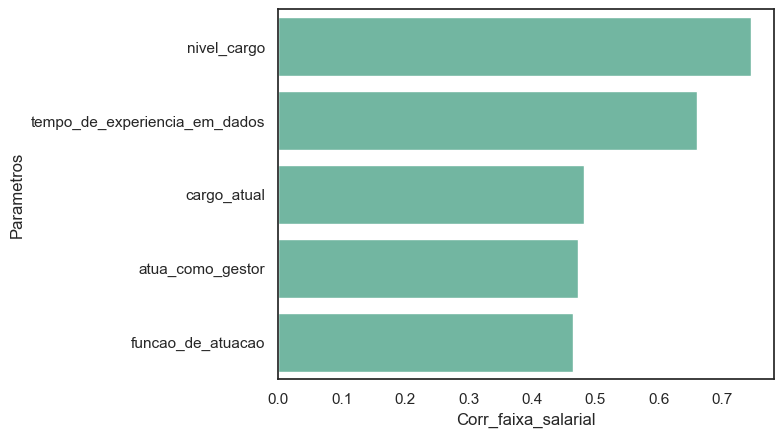

In [92]:
sns.barplot(data=top_param, x ='Corr_faixa_salarial' , y='Parametros');

In [115]:
#Parâmentros que tem baixa relação com a Faixa Salarial
bottom_param = pd.DataFrame(resultados_correlacao["faixa_salarial"].sort_values(ascending=False).drop('faixa_salarial'))[8:12]

In [117]:
bottom_param = bottom_param.reset_index(names='Parametros')
bottom_param = bottom_param.rename(columns={'faixa_salarial': 'Corr_faixa_salarial'})

In [118]:
bottom_param

Parametros  Corr_faixa_salarial
0         área_de_formação             0.013746
1         setor_da_empresa            -0.004158
2  linguagem_R_no_trabalho            -0.044365
3           vive_no_brasil            -0.053711

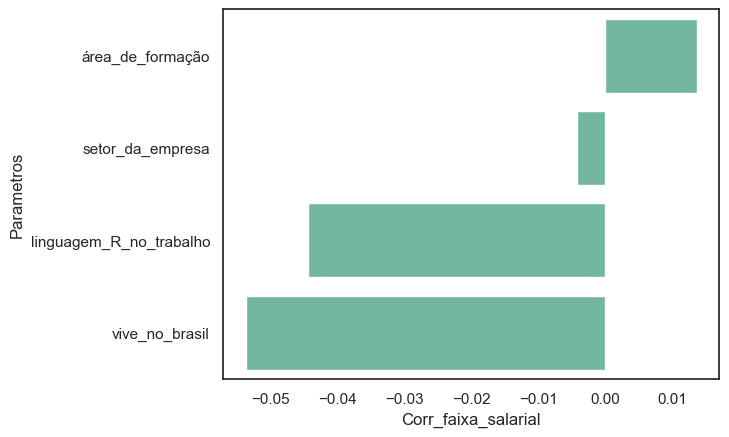

In [119]:
sns.barplot(data=bottom_param, x ='Corr_faixa_salarial' , y='Parametros');